## Electric Motor Temperature Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
data = pd.read_csv('D:\dataset\\Temperature\\pmsm_temperature_data.csv')

data.head()

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,profile_id
0,-0.752143,-1.118446,0.327935,-1.297858,-1.222428,-0.250182,1.029572,-0.245860,-2.522071,-1.831422,-2.066143,-2.018033,4
1,-0.771263,-1.117021,0.329665,-1.297686,-1.222429,-0.249133,1.029509,-0.245832,-2.522418,-1.830969,-2.064859,-2.017631,4
2,-0.782892,-1.116681,0.332771,-1.301822,-1.222428,-0.249431,1.029448,-0.245818,-2.522673,-1.830400,-2.064073,-2.017343,4
3,-0.780935,-1.116764,0.333700,-1.301852,-1.222430,-0.248636,1.032845,-0.246955,-2.521639,-1.830333,-2.063137,-2.017632,4
4,-0.774043,-1.116775,0.335206,-1.303118,-1.222429,-0.248701,1.031807,-0.246610,-2.521900,-1.830498,-2.062795,-2.018145,4


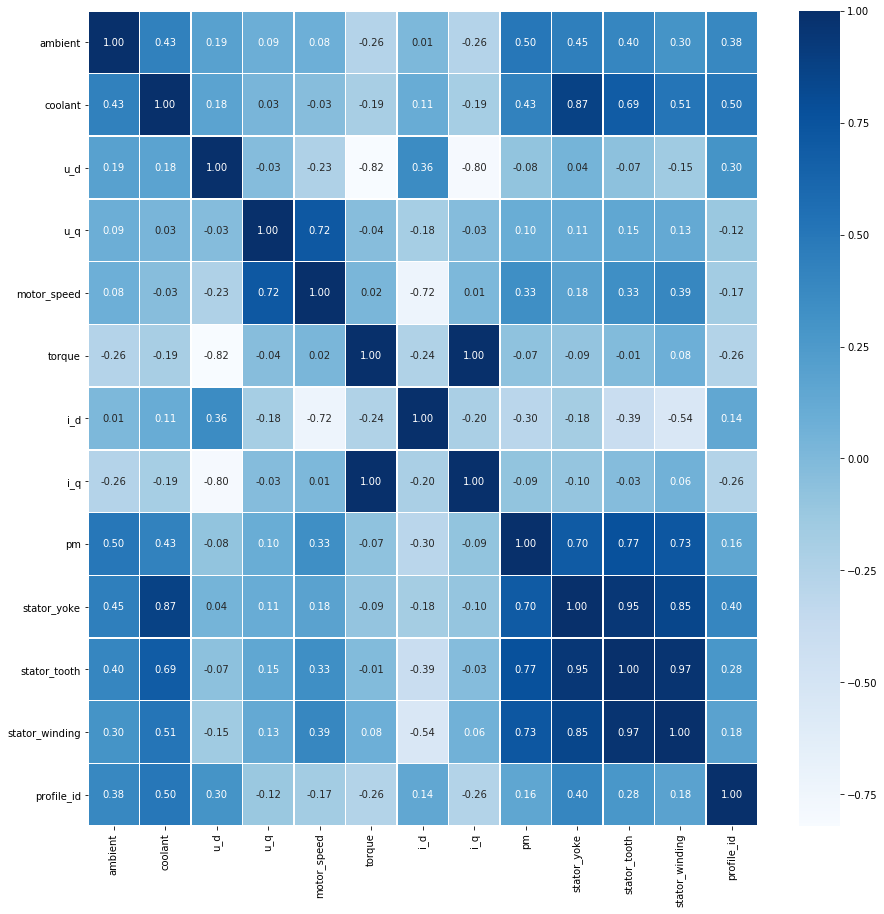

In [ ]:
import matplotlib.pyplot as plt 
import seaborn as sns    
plt.figure(figsize=(15,15))
sns.heatmap(data = data.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

In [ ]:
target = data.loc[:,["pm","stator_yoke","stator_tooth","stator_winding"]]
target

,pm,stator_yoke,stator_tooth,stator_winding
0,-2.522071,-1.831422,-2.066143,-2.018033
1,-2.522418,-1.830969,-2.064859,-2.017631
2,-2.522673,-1.830400,-2.064073,-2.017343
3,-2.521639,-1.830333,-2.063137,-2.017632
4,-2.521900,-1.830498,-2.062795,-2.018145
...,...,...,...,...
998065,0.429853,1.018568,0.836084,0.494725
998066,0.429751,1.013417,0.834438,0.494279
998067,0.429439,1.002906,0.833936,0.492666
998068,0.429558,0.999157,0.830504,0.490581


In [ ]:
target.corr()

,pm,stator_yoke,stator_tooth,stator_winding
pm,1.000000,0.695014,0.768352,0.729561
stator_yoke,0.695014,1.000000,0.949898,0.845144
stator_tooth,0.768352,0.949898,1.000000,0.965633
stator_winding,0.729561,0.845144,0.965633,1.000000


* torque를 제외한 pm, stator_yoke, stator_tooth, stator_widing이 높은 상관관계를 보이고 있음.

# pm~stator_winding을 PCA를 통하여 차원축소 진행.
-> torque는 단일 모델로 사용하고, PCA모델의 결과와 결합.

-> torque와 PCA의 모델은 독립적이기 때문.

In [ ]:
from sklearn.decomposition import PCA

pca_target = target
pca_target.head()

,pm,stator_yoke,stator_tooth,stator_winding
0,-2.522071,-1.831422,-2.066143,-2.018033
1,-2.522418,-1.830969,-2.064859,-2.017631
2,-2.522673,-1.830400,-2.064073,-2.017343
3,-2.521639,-1.830333,-2.063137,-2.017632
4,-2.521900,-1.830498,-2.062795,-2.018145


In [ ]:
pca = PCA(n_components=4)
Xlow = pca.fit_transform(pca_target)

In [ ]:
pca_target2 = pca.inverse_transform(Xlow)

In [ ]:
pd.DataFrame(Xlow).head()

,0,1,2,3
0,-4.183849,0.710603,-0.043310,-0.003917
1,-4.182892,0.711435,-0.043231,-0.004637
2,-4.182157,0.712094,-0.043353,-0.004954
3,-4.181306,0.711346,-0.043639,-0.005771
4,-4.181587,0.711486,-0.043841,-0.006350


In [ ]:
pd.DataFrame(pca_target2).head()

,0,1,2,3
0,-2.522071,-1.831422,-2.066143,-2.018033
1,-2.522418,-1.830969,-2.064859,-2.017631
2,-2.522673,-1.830400,-2.064073,-2.017343
3,-2.521639,-1.830333,-2.063137,-2.017632
4,-2.521900,-1.830498,-2.062795,-2.018145


In [ ]:
pca.components_

array([[ 0.45217019,  0.50401587,  0.53076494,  0.50970452],
       [-0.88599958,  0.34880767,  0.21982701,  0.21216512],
       [-0.09052286, -0.69902815,  0.06235971,  0.70659502],
       [ 0.04850236,  0.36832167, -0.81613475,  0.44261806]])

In [ ]:
pca.explained_variance_ratio_

array([8.71991852e-01, 8.90531508e-02, 3.84125504e-02, 5.42446431e-04])

* 주성분의 누적기여율이 각각 0.87, 0.08, 0.03, 0.0005 이므로 첫 번째 주성분만 사용해도 무방하다고 판단. 

* 따라서 종속변수로 PCA1(= 0.45pm + 0.5stator_yoke + 0.53stator_tooth + 0.5stator_winding) 결정.

* torque의 경우 온도가 아닌 물리적인 값이므로 제외.

In [ ]:
pca_R = PCA(n_components = 1)
Xlow_R = pca_R.fit_transform(pca_target)
y_pca = pd.DataFrame(Xlow_R, columns = ["y_PCA1"])
y_pca.head()

,y_PCA1
0,-4.183849
1,-4.182892
2,-4.182157
3,-4.181306
4,-4.181587


In [ ]:
pd.DataFrame(pca.inverse_transform(Xlow_R)).head()

,0,1,2,3
0,-1.896208,-2.108117,-2.222848,-2.136462
1,-1.895775,-2.107635,-2.222340,-2.135974
2,-1.895442,-2.107264,-2.221950,-2.135599
3,-1.895058,-2.106835,-2.221498,-2.135165
4,-1.895185,-2.106977,-2.221647,-2.135308


In [ ]:
target.head()

,pm,stator_yoke,stator_tooth,stator_winding
0,-2.522071,-1.831422,-2.066143,-2.018033
1,-2.522418,-1.830969,-2.064859,-2.017631
2,-2.522673,-1.830400,-2.064073,-2.017343
3,-2.521639,-1.830333,-2.063137,-2.017632
4,-2.521900,-1.830498,-2.062795,-2.018145
